In [15]:
from pathlib import Path
import xarray as xr
import geopandas as gpd

import matplotlib.pyplot as plt

In [12]:
gdf = gpd.read_file('/Users/rdcrlzh1/Documents/arctic-radarsat2/data/FY24_OLI_UTQ_rsgis_coherance_aois/FY24_OLI_UTQ_rsgis_coherance_aois.shp')
gdf = gdf[gdf.Location == 'Oliktok']

In [27]:
for fp in list(Path('/Users/rdcrlzh1/Documents/arctic-radarsat2/data/s1/oliktok').glob('*summer*.tif')):
    ds = xr.open_dataarray(fp).squeeze('band', drop = True) / 100

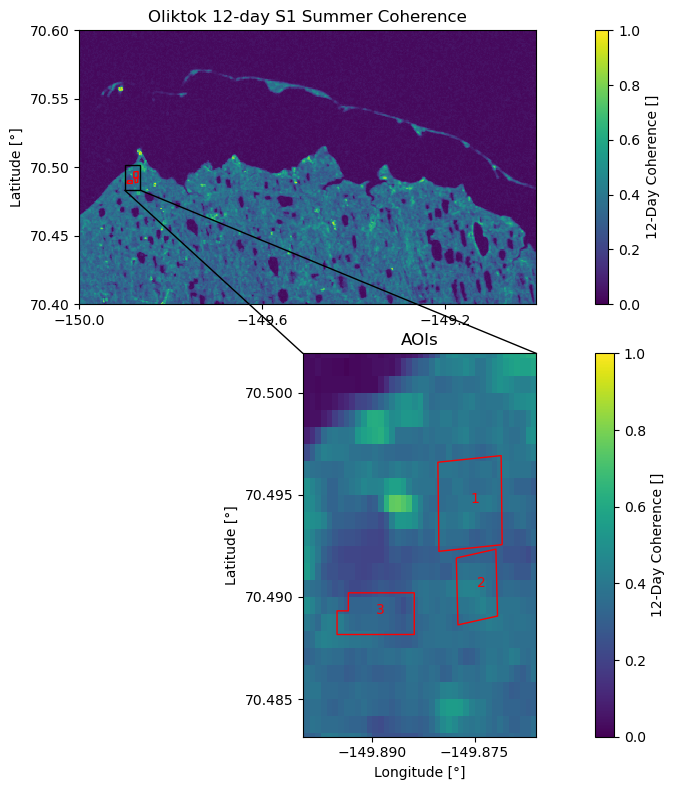

In [30]:
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

fig, axes= plt.subplots(2, 1, figsize = (12, 8), height_ratios= [5, 7])

ax = axes[0]
ds.plot(ax = ax, vmin = 0, vmax = 1, add_colorbar=True, cbar_kwargs= {'label': '12-Day Coherence []'})
ax.set_ylim(70.4, 70.6)

ds.plot(ax = axes[1], vmin = 0, vmax = 1, add_colorbar=True, cbar_kwargs= {'label': '12-Day Coherence []'})


for ax in axes:
    ax.ticklabel_format(axis = 'both', style = 'plain', useOffset = False)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.set_ylabel('Latitude [°]')
    ax.set_facecolor("grey")
    gdf[gdf.Location == 'Oliktok'].plot(ax = ax, facecolor = "none", edgecolor = 'red')

xmin, ymin, xmax, ymax = gdf[gdf.Location == 'Oliktok'].total_bounds
buff = 0.005
axes[1].set_xlim(xmin - buff, xmax + buff)
axes[1].set_ylim(ymin - buff, ymax + buff)
width = (xmax + buff) - (xmin - buff)
height = (ymax + buff) - (ymin - buff)
rect = patches.Rectangle((xmin - buff, ymin - buff), width, height, linewidth=1, edgecolor='black', facecolor='none')
# Add the patch to the Axes
axes[0].add_patch(rect)
con1 = ConnectionPatch(xyA=(xmin - buff, ymin - buff), xyB=(xmin - buff, ymax + buff), coordsA="data", coordsB="data", axesA=axes[0], axesB=axes[1], color="black")
axes[0].add_artist(con1)
con1 = ConnectionPatch(xyA=(xmax + buff, ymin - buff), xyB=(xmax + buff, ymax + buff), coordsA="data", coordsB="data", axesA=axes[0], axesB=axes[1], color="black")
axes[0].add_artist(con1)

for i, r in gdf[gdf.Location == 'Oliktok'].iterrows():
    xmin, ymin, xmax, ymax = r.geometry.bounds
    xc, yc = (xmax + xmin) /2  , (ymin + ymax) / 2
    axes[1].text(xc, yc, r.Priority, color = 'red')

axes[0].set_xlabel('')
axes[1].set_xlabel('Longitude [°]')
axes[0].set_title('Oliktok 12-day S1 Summer Coherence')
axes[1].set_title('AOIs')

plt.tight_layout()
plt.subplots_adjust(hspace=0.15)

TypeError: No numeric data to plot.

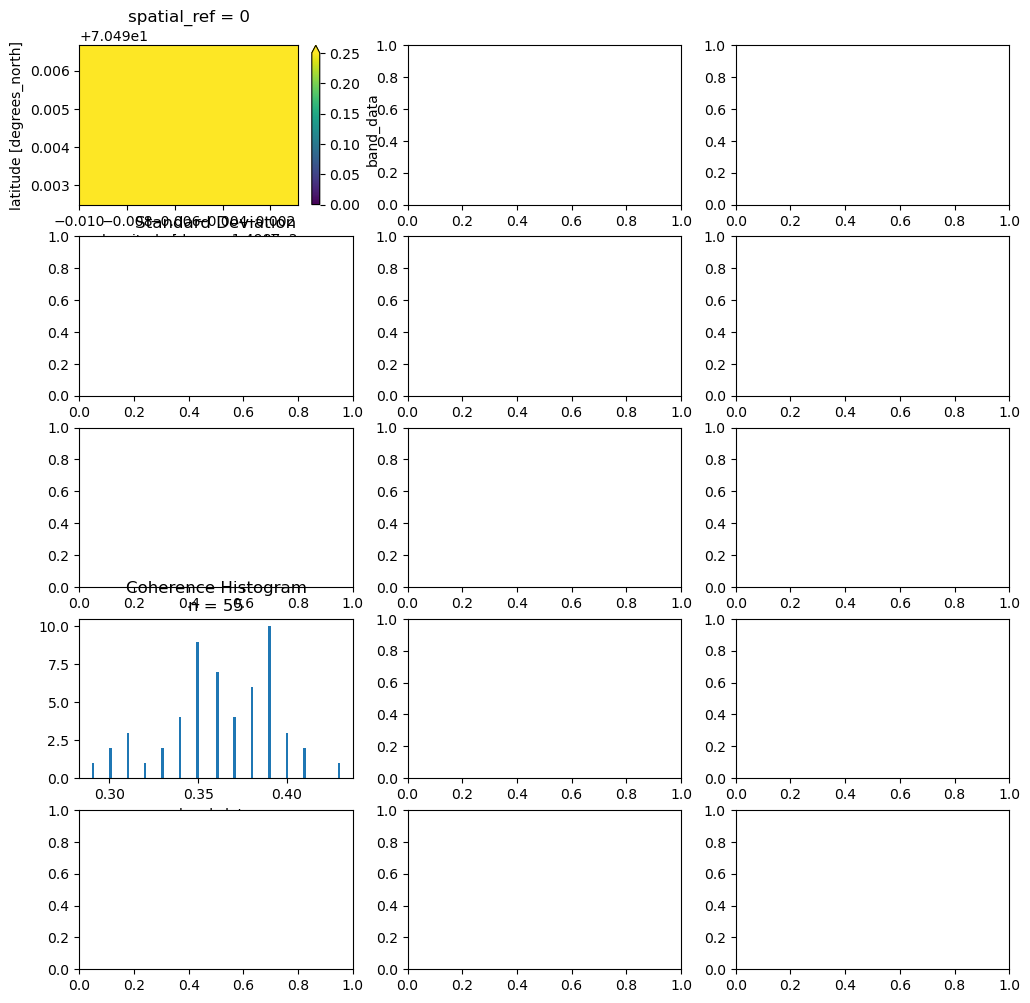

In [32]:
from itertools import product
fig, axes= plt.subplots(5, 3, figsize = (12, 12))
for i, (ind, r) in enumerate(gdf[gdf.Location == 'Oliktok'].iterrows()):
    geom = [r.geometry]
    sub = ds.rio.clip(geom, 'EPSG:4326')
    sub = sub.where((sub > 0) & (sub < 1))

    sub.mean(['time1','time2']).plot(ax = axes[0, i], vmin = 0, vmax = 0.25)
    sub.std(['time1','time2']).plot(ax = axes[1, i], vmin = 0, vmax = 0.25)
    axes[1, i].set_title('Standard Deviation')

    sub.plot.hist(ax = axes[3, i], bins = 100)
    axes[3, i].set_title(f'Coherence Histogram\nn = {sub.size}')

    sub.mean(['x', 'y']).plot(vmax = 0.45, vmin = 0, ax= axes[4, i])
    axes[4, i].set_xlabel('Reference Image')
    axes[4, 0].set_ylabel('Secondary Image')
    for ax in axes[4, 1:]: ax.set_ylabel(''); ax.set_yticklabels([])
    
    dts = []
    cors = []
    for t1, t2  in product(sub.time1.values, sub.time2.values):
        cor = sub.sel(time1 = t1, time2 = t2).mean()
        dt = t1 - t2
        axes[2, i].scatter(pd.Timedelta(dt).days, cor, color = 'black')
        axes[2, i].set_xlim(0, 100)
        axes[2, i].set_ylim(0, 0.5)
        dts.append(pd.Timedelta(dt).days)
        cors.append(cor.values.ravel()[0])

    ix = (~np.isnan(cors)) & (~np.isnan(dts))
    cors, dts = np.array(cors)[ix], np.array(dts)[ix]
    gamm_inf, tau, _ = fit_coh_decay_model(cors, dts, 5, [[0,0], [20,30]], 1, 1, gamma_inf_guess=0.05)
    x = np.linspace(0, np.max(dts), 10)
    y = decorrelation_temporal_model(x, gamm_inf, tau)
    axes[2, i].plot(x, y)
    
    axes[0, i].set_title(f'Oliktok Priority: {r.Priority}\n Mean Coherence')

    axes[2, i].set_title('n = 10')
    axes[2, i].set_xlabel('Temporal Baseline [days]')
    axes[2, i].set_ylabel('Coherence []')
    axes[2, i].set_title('Image Pair Coherence')
    axes[4, i].set_xticks(sub.time2); axes[4, i].set_yticks(sub.time1)
    axes[4, i].set_title('Image Pair AOI Coherence')

axes[2, 1].set_title('Temporal Decay (n = 10)')
for ax in axes[:2, :].ravel(): 
    ax.ticklabel_format(axis = 'both', style = 'plain',useOffset = False); ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.set_xlabel('Longitude [°]')
    ax.set_ylabel('Latitude [°]')
# for ax in axes[1, :].ravel(): ax.set_xticks(sub.time2); ax.set_yticks(sub.time1)

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)